In [62]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import sklearn
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [9]:
df = pd.read_csv('vaccination_tweets.csv')

In [6]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10340 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [11]:
df.isnull().sum()

id                     0
user_name              0
user_location       2270
user_description     680
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [12]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [13]:
text_df = df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'], axis=1)
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [14]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4 

Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq 



In [15]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11020 non-null  object
dtypes: object(1)
memory usage: 86.2+ KB


In [16]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [17]:
text_df.text = text_df['text'].apply(data_processing)

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/khalil/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [18]:
text_df = text_df.drop_duplicates('text')

In [19]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [20]:
text_df['text'] = text_df['text'].apply(lambda x: stemming(x))

In [21]:
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [22]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4 

Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq 



In [23]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11013 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11013 non-null  object
dtypes: object(1)
memory usage: 172.1+ KB


In [24]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [25]:
text_df['polarity'] = text_df['text'].apply(polarity)

In [26]:
text_df.head(10)

,text,polarity
0,Same folks said daikon paste could treat a cyt...,0.000
1,While the world has been on the wrong side of ...,-0.500
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,0.000
3,"Facts are immutable, Senator, even when you're...",-0.050
4,Explain to me again why we need a vaccine @Bor...,0.000
5,Does anyone have any useful advice/guidance fo...,0.400
6,it is a bit sad to claim the fame for success ...,-0.100
7,There have not been many bright days in 2020 b...,0.675
8,Covid vaccine; You getting it?\n\n #CovidVacci...,0.000
9,#CovidVaccine \n\nStates will start getting #C...,0.000


In [27]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [28]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [29]:
text_df.head()

,text,polarity,sentiment
0,Same folks said daikon paste could treat a cyt...,0.00,Neutral
1,While the world has been on the wrong side of ...,-0.50,Negative
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,0.00,Neutral
3,"Facts are immutable, Senator, even when you're...",-0.05,Negative
4,Explain to me again why we need a vaccine @Bor...,0.00,Neutral


<Axes: xlabel='sentiment', ylabel='count'>

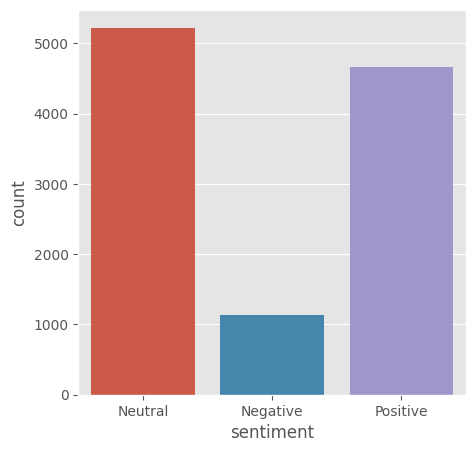

In [30]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

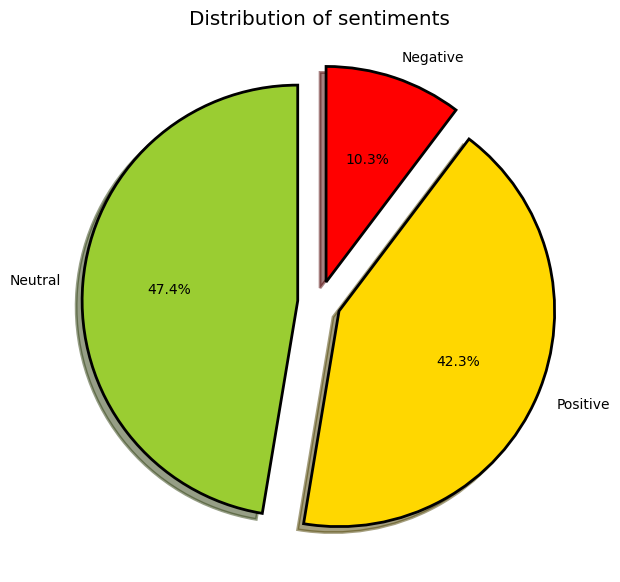

In [31]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [32]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,text,polarity,sentiment
6575,The best 😂😂😂😂\n#CovidVaccine #PfizerBiontech h...,1.0,Positive
9916,Ok. It’s been a day now. Can we please list th...,1.0,Positive
5923,Great news! Now let's scale up production worl...,1.0,Positive
5942,VACCINES WORK. \n\nExcellent news⤵️ \n\n@TheL...,1.0,Positive
5948,89.4% reduction in #COVIDー19 transmission. A g...,1.0,Positive


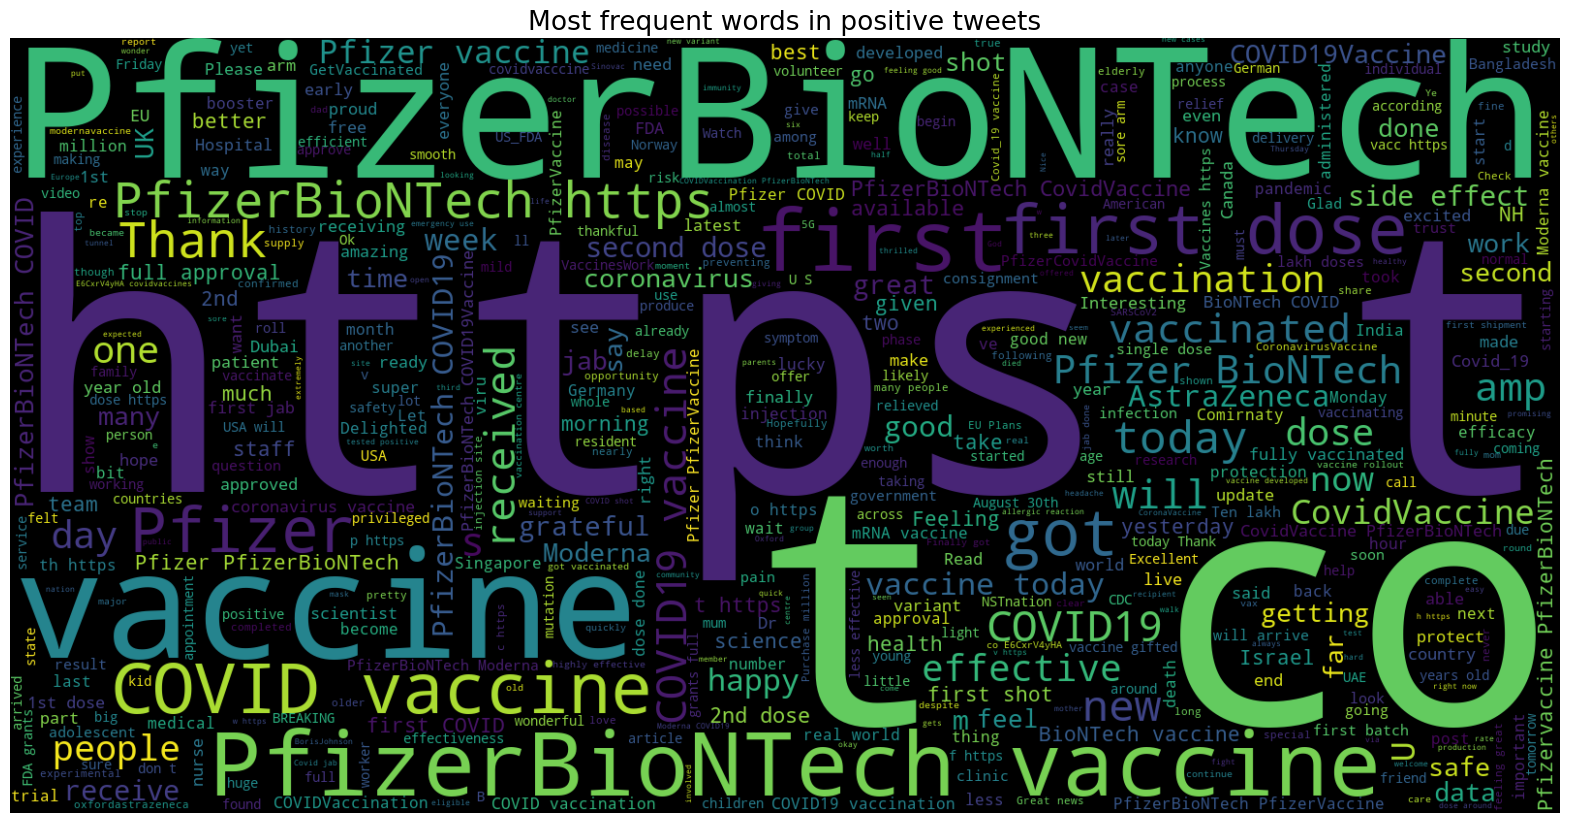

In [33]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [34]:
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,text,polarity,sentiment
3940,"Vaccines can have side effects, but they are e...",-9.251859e-18,Negative
8172,"This should make ""vaccination-center"" life muc...",-4.166667e-03,Negative
7157,@Nas_k27 My second dose due end of next month ...,-6.250000e-03,Negative
2907,In 2015 we were worried about absence of mRNA ...,-6.250000e-03,Negative
5649,My arm is a little sore 😔 \nBut so far no othe...,-8.333333e-03,Negative


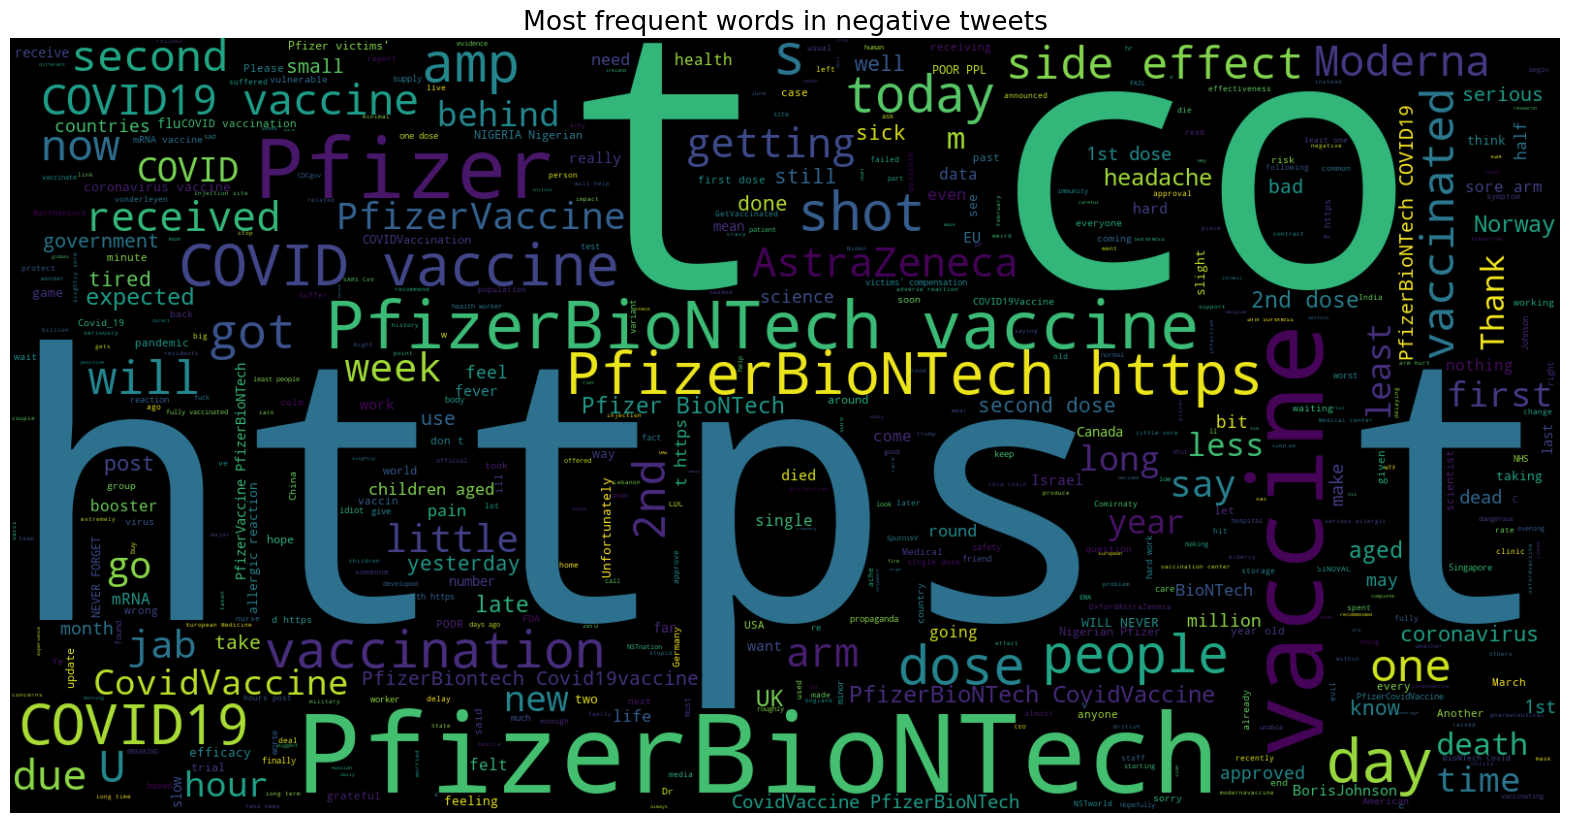

In [35]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [36]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,text,polarity,sentiment
0,Same folks said daikon paste could treat a cyt...,0.0,Neutral
7557,2nd dose #PfizerBiontech #COVID19Vaccination h...,0.0,Neutral
7599,Had my second #PfizerBiontech #CovidVaccine do...,0.0,Neutral
7596,"#NSTnation A total of 25,770 cases or 3.5 per ...",0.0,Neutral
7595,#PfizerProud 👇🏻 of our leadership - #PFECollea...,0.0,Neutral


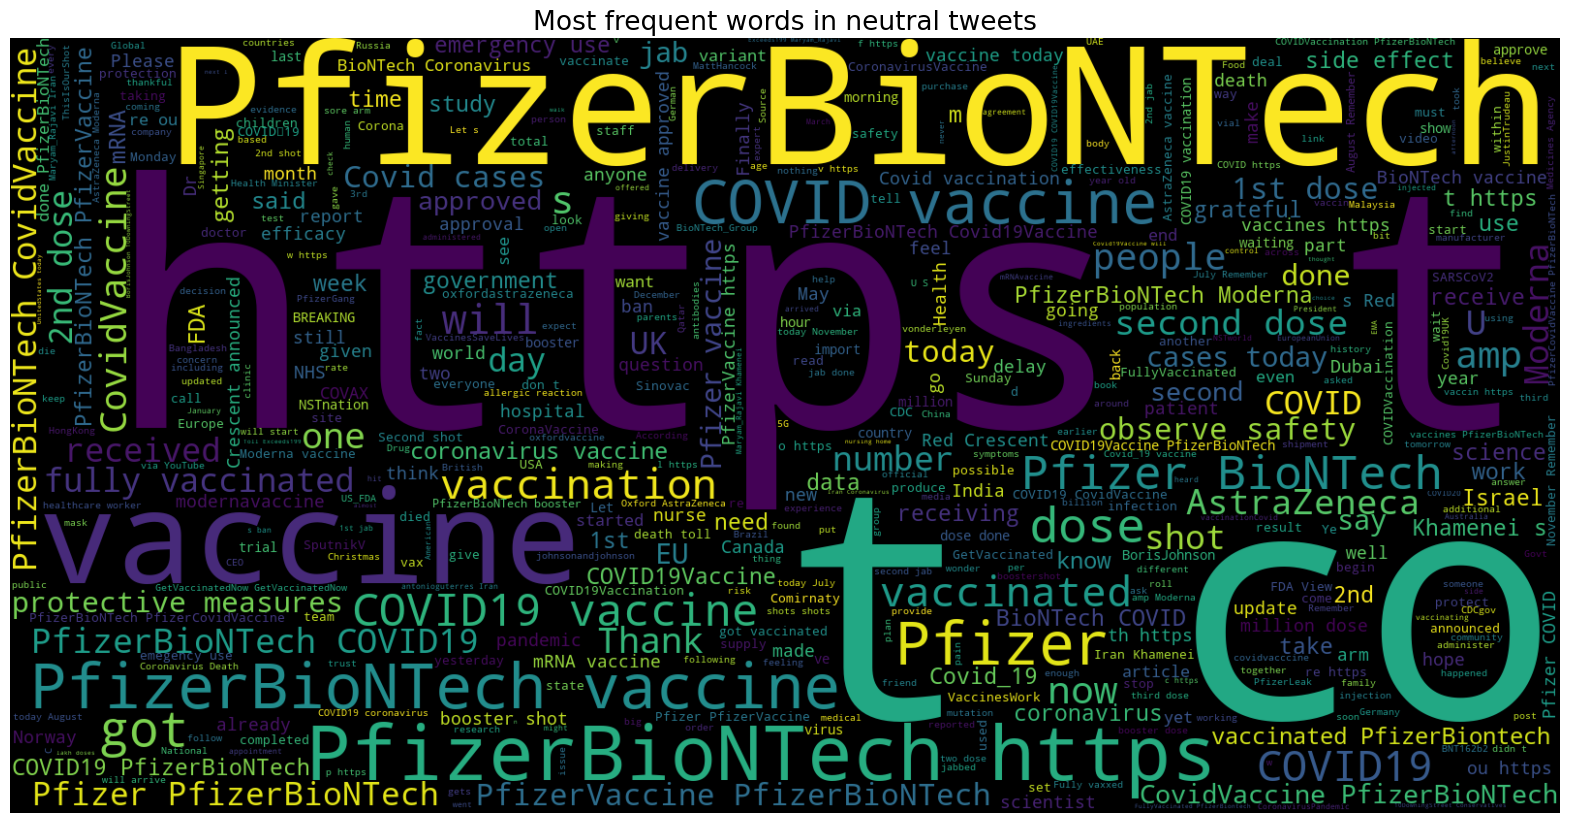

In [37]:
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

In [60]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])

In [61]:
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [40]:
X = text_df['text']
Y = text_df['sentiment']
X = vect.transform(X)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [42]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (8810, 113986)
Size of y_train: (8810,)
Size of x_test: (2203, 113986)
Size of y_test: (2203,)


In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 84.20%


In [45]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 75 118  53]
 [  6 997  43]
 [ 14 114 783]]


              precision    recall  f1-score   support

    Negative       0.79      0.30      0.44       246
     Neutral       0.81      0.95      0.88      1046
    Positive       0.89      0.86      0.87       911

    accuracy                           0.84      2203
   macro avg       0.83      0.71      0.73      2203
weighted avg       0.84      0.84      0.83      2203



Additional code to extract data form twitter using twitter api

In [1]:
import tweepy #to access the twitter api
import pandas as pd #for basic data operations

In [2]:
# Importing the keys from twitter api
consumerKey = "nV211cauWjRmdu9a613t7bXON"
consumerSecret = "BhUXQCxACTexmi0Y1A7qvpLaAKrIKfnJCphlWYhjTmP33wNYkb"
accessToken = "4559785366-e3uLZEyJhIxTf4Gu01s99FS1CnZ5cONLiUmyj4C"
accessTokenSecret = "etuvGy3TxNjuua0NDNu1WgyfenNgauhSXtSxLRl729Qpl"

In [6]:
# Establish the connection with twitter API
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

In [7]:
# Search for the Term and define number of tweets 
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many tweets to search: "))

Enter Keyword/Tag to search about: #corona
Enter how many tweets to search: 10


In [8]:
# Get no of tweets and searched term together 
tweets = tweepy.Cursor(api.search, q=searchTerm).items(NoOfTerms)

AttributeError: 'API' object has no attribute 'search'